In [88]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.svm import OneClassSVM
from os import listdir, getcwd
from os.path import isfile, join, dirname

In [89]:
#Read in Input Path Where Datafiles are Stored, keep as a list of files
try:
    input_path = dirname(getcwd()) + "\\Data\\Test_Data\\"
    onlyfiles = [f for f in listdir(input_path) if isfile(join(input_path, f))]
except Exception as e:
    print("Error Reading in Dataset Files, Check Input Path")
    print(e)
else:
    print("Dataset Files Loaded In")

#Read in Each File and Store it into One Large Dataframe, Skipping Files that Don't Contain 'SEQN' Column
try:
    df_init = pd.DataFrame()
    i = 0
    for filename in onlyfiles:
        if i == 0:
            df_init = pd.read_sas(input_path + filename) 
            i+=1
        else: 
            df_next = pd.read_sas(input_path + filename)
            if 'SEQN' not in df_next:
                print(filename + " does not have 'SEQN' column, skipping this file")
                i+=1
                next
            else:
                df_init = pd.merge(df_init,df_next,how = 'outer', on = 'SEQN')
                i+=1
except Exception as e:
    print("Error Loading in Data")
    print(e)
else:
    print("Datasets Merged into One Dataframe")
    
#MCQ220 - Have you been diagnosed with cancer
#MCQ230a -What kind was it

#Identify Response Variable Column, And Begin Dataframe Cleaning
response = "MCQ220"

Dataset Files Loaded In
RXQ_DRUG.xpt does not have 'SEQN' column, skipping this file
Datasets Merged into One Dataframe


In [108]:
#Keep Only Rows that Have Response Variable
df_init_1 = df_init[df_init[response].notna()]

#Drop Columns With More than 30% of Rows Missing

perc = 30 # Like N %
min_count =  int(((100-perc)/100)*df_init_1.shape[0] + 1)
df_init_2 = df_init_1.dropna( axis=1, 
                thresh=min_count)

#Impute Missing Values with Median of Column

df_init_3 = df_init_2.fillna(df_init_2.median())
df_init_3 = df_init_3.select_dtypes(exclude=['object'])


#Remove Outliers with one_class_SVM

# identify 5% of data as outliers in the training dataset
ee = OneClassSVM(nu = .05)
yhat = ee.fit_predict(df_init_3)
mask = yhat != -1

# select all rows that are not outliers
df_init_4 = df_init_3[mask]


#Create Correlation Matrix and Remove Correlated Variables
corr_matrix = df_init_4.corr()

<ipython-input-108-1fe65a2ac5f5>:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_init_3 = df_init_2.fillna(df_init_2.median())


,SEQN,ALQ111,ALQ121,ALQ151,AUQ054,BPQ020,BPQ080,BPQ070,BPQ090D,WTDRD1_x,...,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190
SEQN,1.000000,-0.005935,-0.012819,0.012498,0.001096,0.000740,-0.016845,0.032250,-0.025702,-0.019981,...,-0.030529,0.002554,-0.021206,0.013237,0.037513,-0.012274,0.013315,0.015261,0.033136,-0.013059
ALQ111,-0.005935,1.000000,-0.020445,0.089491,-0.027960,0.014915,-0.002699,-0.023703,-0.015388,-0.052631,...,0.042526,-0.014143,-0.006713,0.029239,0.057810,0.025446,0.075973,0.045915,0.002867,0.028186
ALQ121,-0.012819,-0.020445,1.000000,0.111009,-0.074019,0.066286,0.013822,0.001097,0.033138,0.065036,...,-0.023147,0.009780,-0.065272,-0.042455,-0.011342,-0.044288,-0.037096,-0.027708,-0.007539,-0.014568
ALQ151,0.012498,0.089491,0.111009,1.000000,-0.038535,0.040365,0.017635,-0.026379,-0.033203,0.001072,...,0.046396,0.021026,-0.016950,0.000881,0.025549,0.026818,0.018228,-0.000529,0.026970,0.034210
AUQ054,0.001096,-0.027960,-0.074019,-0.038535,1.000000,-0.074720,-0.011718,-0.021720,-0.039897,-0.018959,...,0.149516,0.009456,0.042765,0.019474,0.120858,0.094096,0.130718,0.144294,0.013562,-0.000592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WHD120,-0.012274,0.025446,-0.044288,0.026818,0.094096,-0.027302,0.020753,-0.015519,-0.023192,-0.061610,...,0.036632,0.100364,0.035193,0.064070,0.370743,1.000000,0.354881,0.256821,0.077171,0.000038
WHD130,0.013315,0.075973,-0.037096,0.018228,0.130718,0.055798,-0.004277,0.007171,-0.027023,-0.060043,...,0.043164,0.059590,-0.006534,0.065088,0.241281,0.354881,1.000000,0.202625,0.020695,0.019955
WHD140,0.015261,0.045915,-0.027708,-0.000529,0.144294,-0.011978,0.018276,0.004411,-0.004184,-0.029093,...,0.045122,0.275535,-0.008413,0.019071,0.350332,0.256821,0.202625,1.000000,-0.011065,-0.002121
WHQ150,0.033136,0.002867,-0.007539,0.026970,0.013562,0.078619,0.024250,-0.000993,-0.023820,-0.024656,...,0.048249,0.087786,0.044792,0.034191,0.148655,0.077171,0.020695,-0.011065,1.000000,0.012415


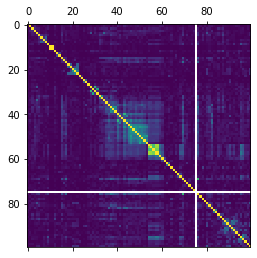

In [114]:
import matplotlib.pyplot as plt

#Create Correlation Matrix and Remove Correlated Variables
corr_matrix = df_init_4.iloc[:, : 100].corr().abs()
corr_matrix

plt.matshow(corr_matrix)
plt.show()

<ipython-input-127-55015a75465b>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


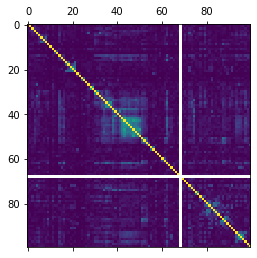

In [127]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]
to_drop

df_init_5 = df_init_4.drop(to_drop, axis=1)
df_init_5

corr_matrix = df_init_5.iloc[:, : 100].corr().abs()
corr_matrix

plt.matshow(corr_matrix)
plt.show()